# Union Simulation

What do we actually want to do here? We want to understand how the network and liqudity is consumed by the network.
We need to loop a bunch of times, select a random agents, select a random action and select random inputs for said action. 

Things we want to measure
- total liqidity (pool balance - total borrowed)
- total members (with at least "effective_number" of vouches)
- total_borrowed
- total_repaid

In [5]:
%matplotlib inline  

import random
import matplotlib.pyplot as plt

rounds = 10000

agents = 250
effective_number = 3

borrow_probability = 25
vouch_probability = 35
repay_probability = 85
stake_probability = 15

max_stake = 1000
max_vouch = 1000
max_borrow = 1000 
min_borrow = 900
max_repay = 100
min_repay = 90

In [6]:
action_names = ["borrow", "repay", "stake", "vouch"]

action_weights = [borrow_probability, repay_probability, stake_probability, vouch_probability]

total_weights = sum(action_weights)

actions_weights = [borrow_probability / total_weights for prop in action_weights]

actions = {
    "borrow": {
        "probability": borrow_probability,
        "min": min_borrow,
        "max": max_borrow,
    },
    "repay": {
        "probability": repay_probability,
        "min": min_repay,
        "max": max_repay,
    },
    "stake": {
        "probability": stake_probability,
        "min": 0,
        "max": max_stake
    },
    "vouch": {
        "probability": vouch_probability,
        "min": 0,
        "max": max_vouch
    }
}

# Simulation

In [7]:
random.seed(10)

udai_pool = 1000

simulation = []
connections = []

stakes = [0 for _ in range(agents)]
borrows = [0 for _ in range(agents)]
locks = [0 for _ in range(agents)]

vouches = [{} for _ in range(agents)]
borrows_to_staker = [{} for _ in range(agents)]

snapshots_per_epoch = []

def get_total_borrowed():
    return sum(borrows)

def get_total_repaid():
    return sum(item["amount"] if item["action"] == "repay" else 0 for item in simulation)

def get_total_vouches(borrower):
    n_vouches = 0
    for i, vouch in enumerate(vouches):
        if borrower in vouch:
            n_vouches+=1
    return n_vouches

def get_total_members():
    return sum(int(is_member(agent)) for agent in range(agents))

def is_member(agent):
    return get_total_vouches(agent) >= effective_number

def get_total_staked():
    return sum(stakes[agent] for agent in range(agents))

def get_total_liquidity():
    return get_total_staked() - get_total_borrowed()

def get_credit_limit(borrower):
    credit_limit = 0
    for staker, vouch in enumerate(vouches):
        if borrower in vouch:
            staked = stakes[staker]
            locked = locks[staker]
            assert(locks[staker] <= stakes[staker])
            borrowed = borrows_to_staker[borrower][staker] if staker in borrows_to_staker[borrower] else 0
            vouch_amount = vouch[borrower]
            chunk = min(staked - locked, vouch_amount - borrowed)
            if chunk > 0:
                credit_limit += chunk
    return credit_limit

def get_total_outstanding(borrower):
    return borrows[borrower]

def borrow(borrower, amount):
    remaining = amount
    for staker, vouch in enumerate(vouches):
        if remaining <= 0:
            break
        if borrower in vouch:
            staked = stakes[staker]
            locked = locks[staker]
            available = staked - locked
            vouch_amount = vouch[borrower]
            outstanding = borrows_to_staker[borrower][staker] if staker in borrows_to_staker[borrower] else 0
            borrow_amount = min([available, amount, vouch_amount - outstanding]) 
            borrows_to_staker[borrower][staker] = outstanding + borrow_amount
            remaining -= borrow_amount
            locks[staker] += borrow_amount
            borrows[borrower] += borrow_amount
            assert(locks[staker] <= stakes[staker])
            
def repay(borrower, amount):
    remaining = amount
    for staker, vouch in enumerate(vouches):
        if remaining <= 0:
            break
        if staker in borrows_to_staker[borrower]:
            locked = locks[staker]
            repay_amount = min([locked, amount])
            borrows_to_staker[borrower][staker] -= repay_amount
            remaining -= repay_amount
            locks[staker] -= repay_amount
            borrows[borrower] -= repay_amount
            assert(locks[staker] <= stakes[staker])

for i in range(rounds):
    
    action_name = random.choices(action_names, weights=action_weights)[0]
    action = actions[action_name]
    
    staker = random.randint(0, agents - 1)
    borrower = random.randint(0, agents - 1)
    while borrower == staker:
        borrower = random.randint(0, agents - 1)
        
    amount = random.randint(action["min"], action["max"])
    
    if action_name == "vouch":
        connections.append({ "staker": staker, "borrower": borrower })
        if borrower not in vouches[staker]:
            vouches[staker][borrower] = amount
    elif action_name == "stake":
        stakes[staker] += amount
    elif action_name == "borrow":
        if is_member(borrower):
            credit_limit = get_credit_limit(borrower)
            assert(credit_limit <= get_total_liquidity()) 
            amount = min([amount, credit_limit, udai_pool])
            borrow(borrower, amount)
    elif action_name == "repay":
        outstanding = get_total_outstanding(borrower)
        amount = min([outstanding, amount])
        repay(borrower, amount)

    simulation.append({
        "action": action_name,
        "amount": amount,
        "total_borrowed": get_total_borrowed(),
        "total_repaid": get_total_repaid(),
        "total_members": get_total_members(),
        "total_liquidity": get_total_liquidity(),
    })

## Graphs

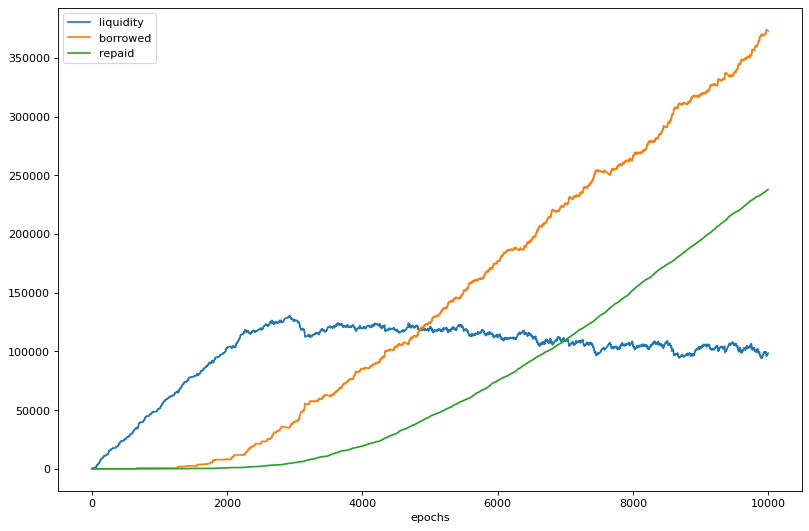

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)

y_total_liquidity = [item["total_liquidity"] for item in simulation]
x_epochs = [i for i, _ in enumerate(simulation)]
plt.plot(x_epochs, y_total_liquidity, label = "liquidity")

y_total_borrowed = [item["total_borrowed"] for item in simulation]
x_epochs = [i for i, _ in enumerate(simulation)]
plt.plot(x_epochs, y_total_borrowed, label = "borrowed")

y_total_repaid = [item["total_repaid"] for item in simulation]
x_epochs = [i for i, _ in enumerate(simulation)]
plt.plot(x_epochs, y_total_repaid, label = "repaid")

plt.xlabel("epochs")
plt.legend()
plt.show()